In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reading and exploring data

In [2]:
adata = sc.read_10x_mtx('C:/Users/aadit/OneDrive - IIT Delhi/Single Cell Sequencing/New Folder (3)', var_names = 'gene_symbols', cache = True)

In [3]:
adata #vars are genes, which are 13136 in number
      # obs are cells, which are 13624 in number

AnnData object with n_obs × n_vars = 13624 × 13136
    var: 'gene_ids'

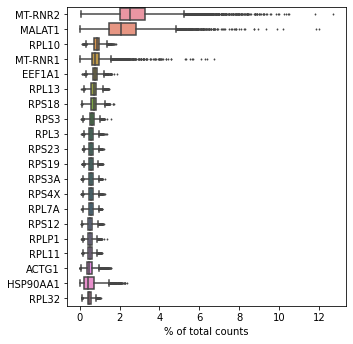

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# Preprocessing data

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') #to filter out mitochondrial genes

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

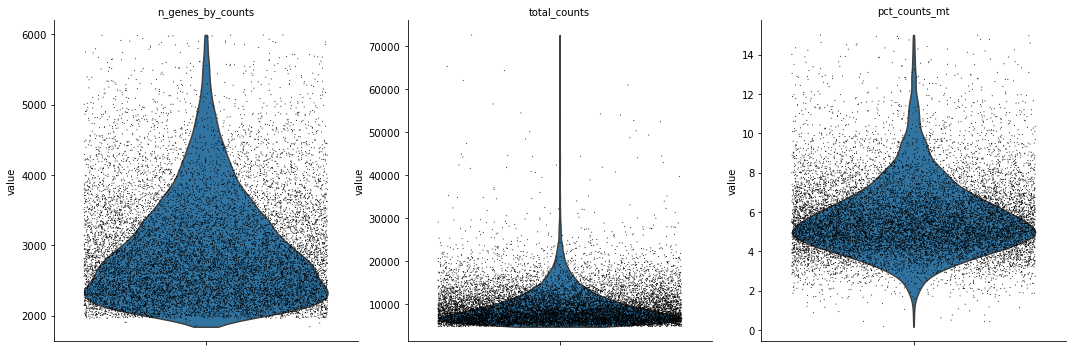

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

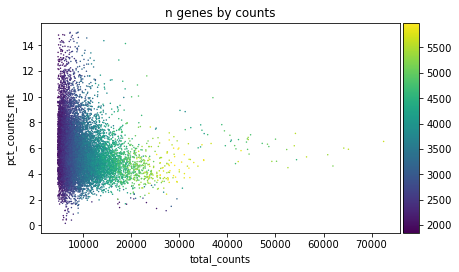

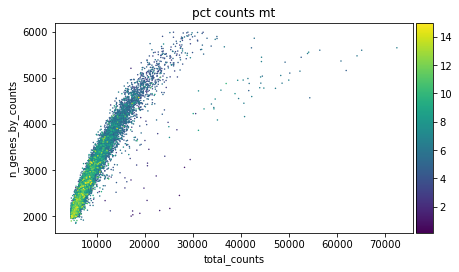

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color  = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt') 
#PLOTS BEFORE FILTERING

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

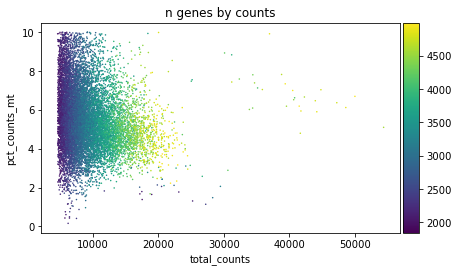

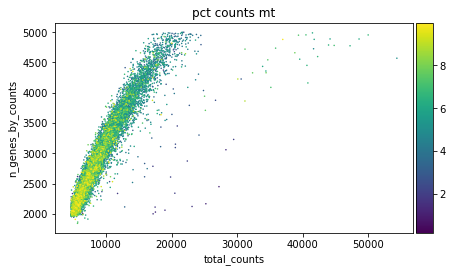

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color  = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')
#PLOTS AFTER FILTERING

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sc.pp.log1p(adata, base = 10)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

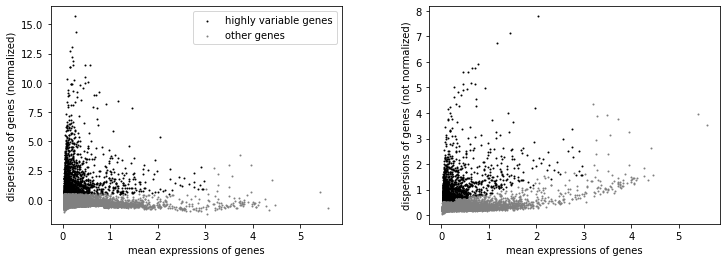

In [15]:
sc.pl.highly_variable_genes(adata) #identify only the biologically variable genes and technically variable genes

In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Linear dimensionality reduction : PCA

In [19]:
sc.pp.scale(adata, max_value=10)

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=55) #each PC is determined by some combinations of genes

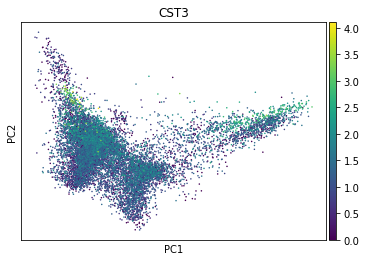

In [21]:
sc.pl.pca(adata, color='CST3') #ONE CAN NOW COLOR WITH ANY GENE (maybe of biological importance) TO VISUALISE ITS EXPRESSION 

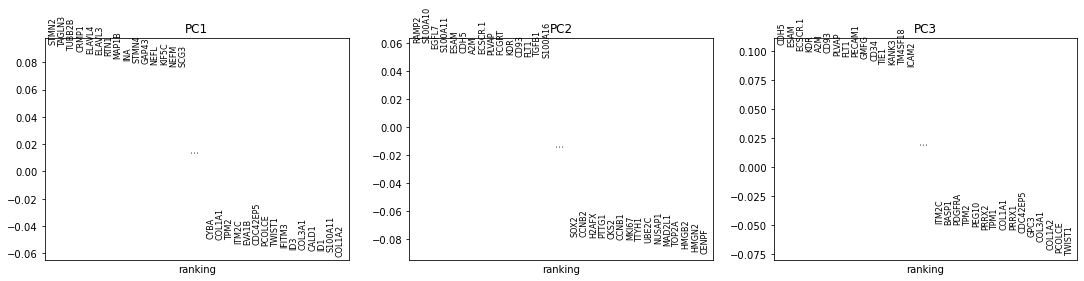

In [22]:
# sc.pl.pca_loadings(adata, components = [i+1 for i in range (adata.obsm['X_pca'].shape[1])])
sc.pl.pca_loadings(adata, components = [i+1 for i in range (3)]) #loading are the scores of each gene in every PC

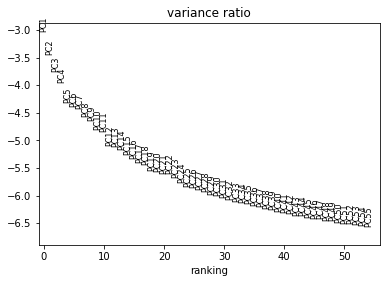

In [23]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = adata.obsm['X_pca'].shape[1])

In [24]:
from kneed import KneeLocator
def PCA_Elbow_fit(data):
    tmp = PCA()
    model = tmp.fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1, explained_variance.shape[0]+1))
    klm = KneeLocator(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing')
    pcs_used = klm.knee
    pcs_used = 23
    pc_list = list(range(1, pcs_used+1))
    new_data = PCA(n_components = pcs_used, svd_solver = "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

In [25]:
label = "adata"
new_frame = pd.DataFrame (adata.X, index=adata.obs_names, columns=adata.var_names) 
pandas_data=new_frame.values
dim, new_matrix,pc_ax,pc_ay,col_labels=PCA_Elbow_fit(pandas_data)

In [26]:
columns = ["PC_" + str(i) for i in col_labels]
# output_path = 
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(), columns=columns)
PC_frame

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23
AAACCCACAACCGTGC,19.766727,1.430667,1.214682,-0.772696,-1.505191,1.811916,-0.054255,-1.030852,-2.144829,-3.160270,...,5.619683,13.892456,-3.309174,3.503813,5.567637,2.067470,3.404587,0.211886,4.002449,1.151942
AAACCCACAAGAAATC,-3.107415,-1.835122,0.093680,-0.312877,0.368519,1.561695,4.593397,-0.599185,2.640188,-0.239854,...,-3.150278,-1.491567,2.691462,3.689604,3.112906,-2.692223,-0.256457,1.237319,-1.262588,-0.985408
AAACCCACACGGTGCT,-2.746903,5.184076,-4.715613,-5.420065,11.501557,13.454039,-7.013371,2.460846,2.360533,-0.429061,...,-4.296677,-1.674994,-0.239268,0.027700,-2.206306,0.927126,-2.330531,2.407490,-1.895506,1.446605
AAACCCACAGTTCCAA,-2.931192,-2.743907,-2.064382,-1.385672,-3.475419,0.004451,-0.474718,-0.434322,1.637681,-1.691331,...,-0.488422,-0.603961,-0.122876,2.816460,5.870196,-2.420152,-1.924366,0.754612,-0.938278,-1.175018
AAACCCACATGAATCC,-1.152660,1.599752,1.854060,-6.683891,-0.296893,2.450097,8.797982,-0.310366,-3.052684,14.280233,...,1.921322,0.280662,-2.426356,-0.093770,-1.205131,2.983462,-1.424335,0.427861,-1.651949,-0.730280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAGTGGGA,14.663792,9.840431,-5.274893,-2.610760,23.156342,19.946270,-13.843268,5.157759,6.279433,1.846301,...,-0.921910,-3.086098,1.697719,-0.934729,5.379386,-3.950626,-0.831432,2.222674,-2.000810,4.083820
TTTGTTGTCCGTTGAA,-1.797756,5.776175,-1.276895,-8.511100,8.281868,-9.051893,3.145449,-5.257415,-0.502868,-0.679136,...,-1.546722,-1.648498,-2.598933,-1.082324,0.230677,-2.910906,-0.400609,-3.820973,0.334239,1.305071
TTTGTTGTCGCGCTGA,5.373508,-5.347184,4.777544,-8.590677,-3.277382,2.216932,-1.684992,-0.162236,-2.481947,0.609931,...,0.126233,-2.687613,0.299537,-1.781585,1.088321,-2.511681,-2.673668,0.587765,1.813911,-1.836601
TTTGTTGTCGTAGTCA,-9.110809,8.158794,0.748548,0.088981,-7.153786,-0.236417,-2.347692,7.892028,-6.205638,-3.666021,...,-2.796112,4.139920,3.813379,-2.029341,-4.225903,-1.584020,-0.980918,0.358731,-3.272687,-1.282034


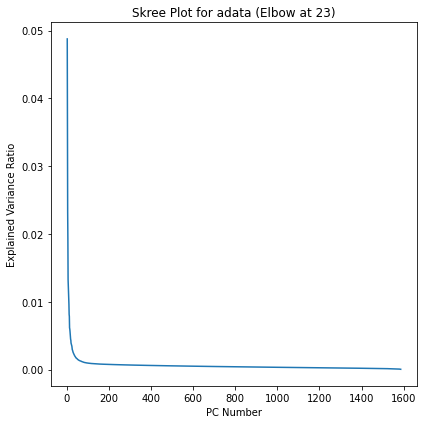

In [27]:
fig= plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for "+label+" (Elbow at "+str(dim)+")") 
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained Variance Ratio")
fig. tight_layout()

In [29]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=dim)

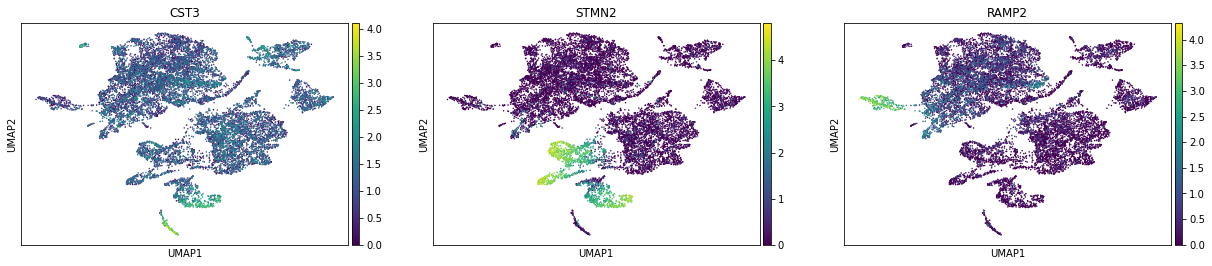

In [30]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'STMN2', 'RAMP2']) #REPLACE/ADD THE NAME OF THE GENE TO VISUALISE ITS GENE EXPRESSION

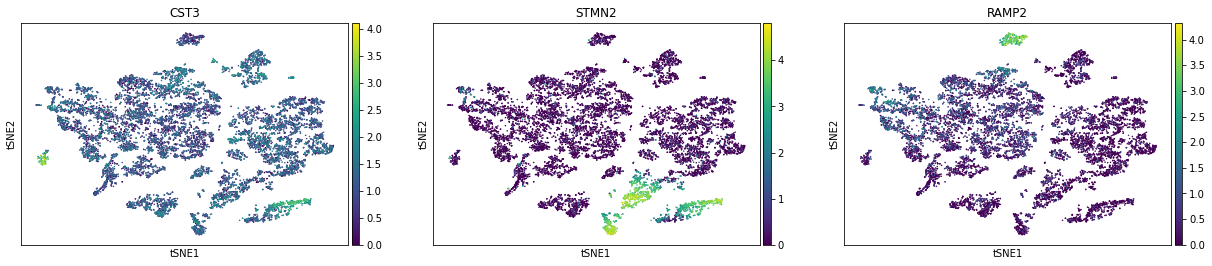

In [38]:
sc.tl.tsne(adata, n_pcs = 23)
sc.pl.tsne(adata, color=['CST3', 'STMN2', 'RAMP2']) #REPLACE/ADD THE NAME OF THE GENE TO VISUALISE ITS GENE EXPRESSION

In [31]:
# !mkdir write
results_file = 'write/this.h5ad'
adata.write(results_file)

In [32]:
sc.tl.leiden(adata, resolution = 0.5)

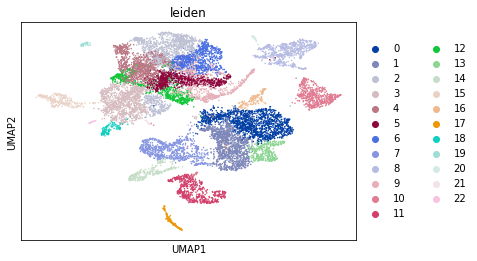

In [33]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga (adata, color=['leiden', 'CST3', 'STMN2'])

In [ ]:
# sc.tl.draw_graph(adata, init_pos='paga') 
# sc.pl.draw_graph(adata, color=['leiden', 'CST3', 'STMN2'], legend_loc='on data')

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually

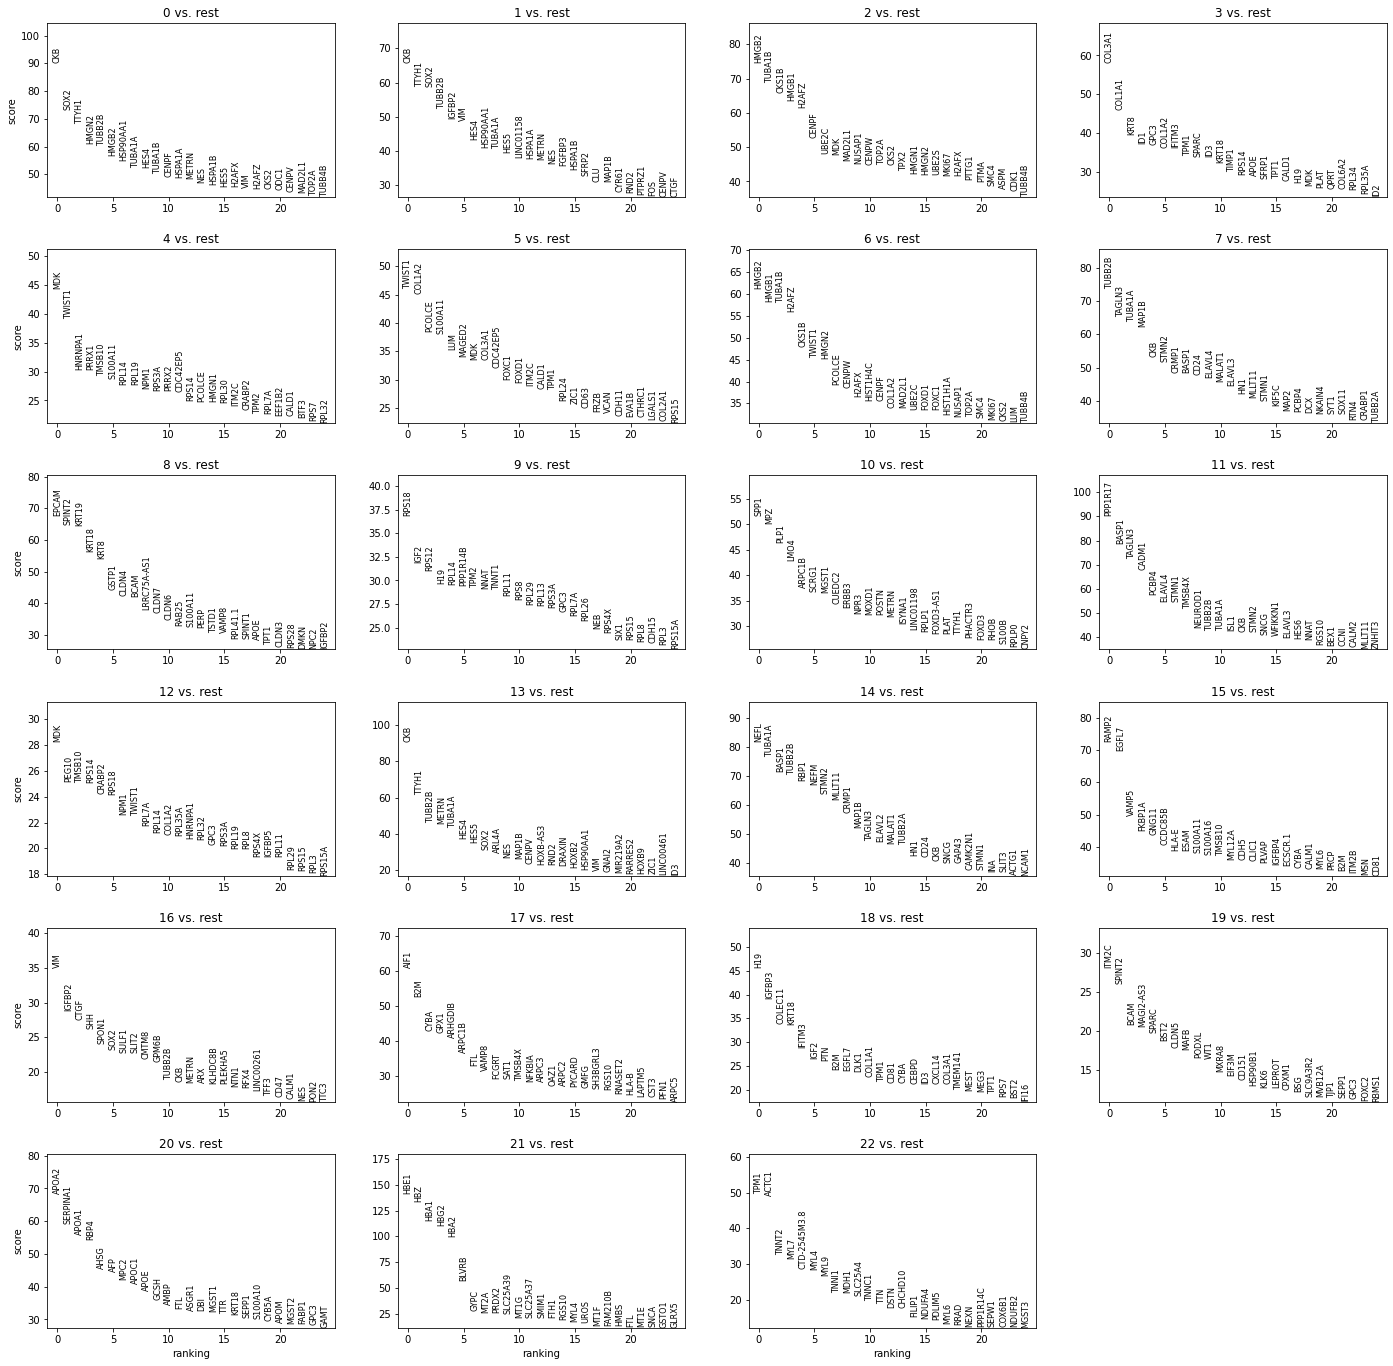

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [42]:
sc.settings.verbosity = 2  # reduce the verbosity

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually

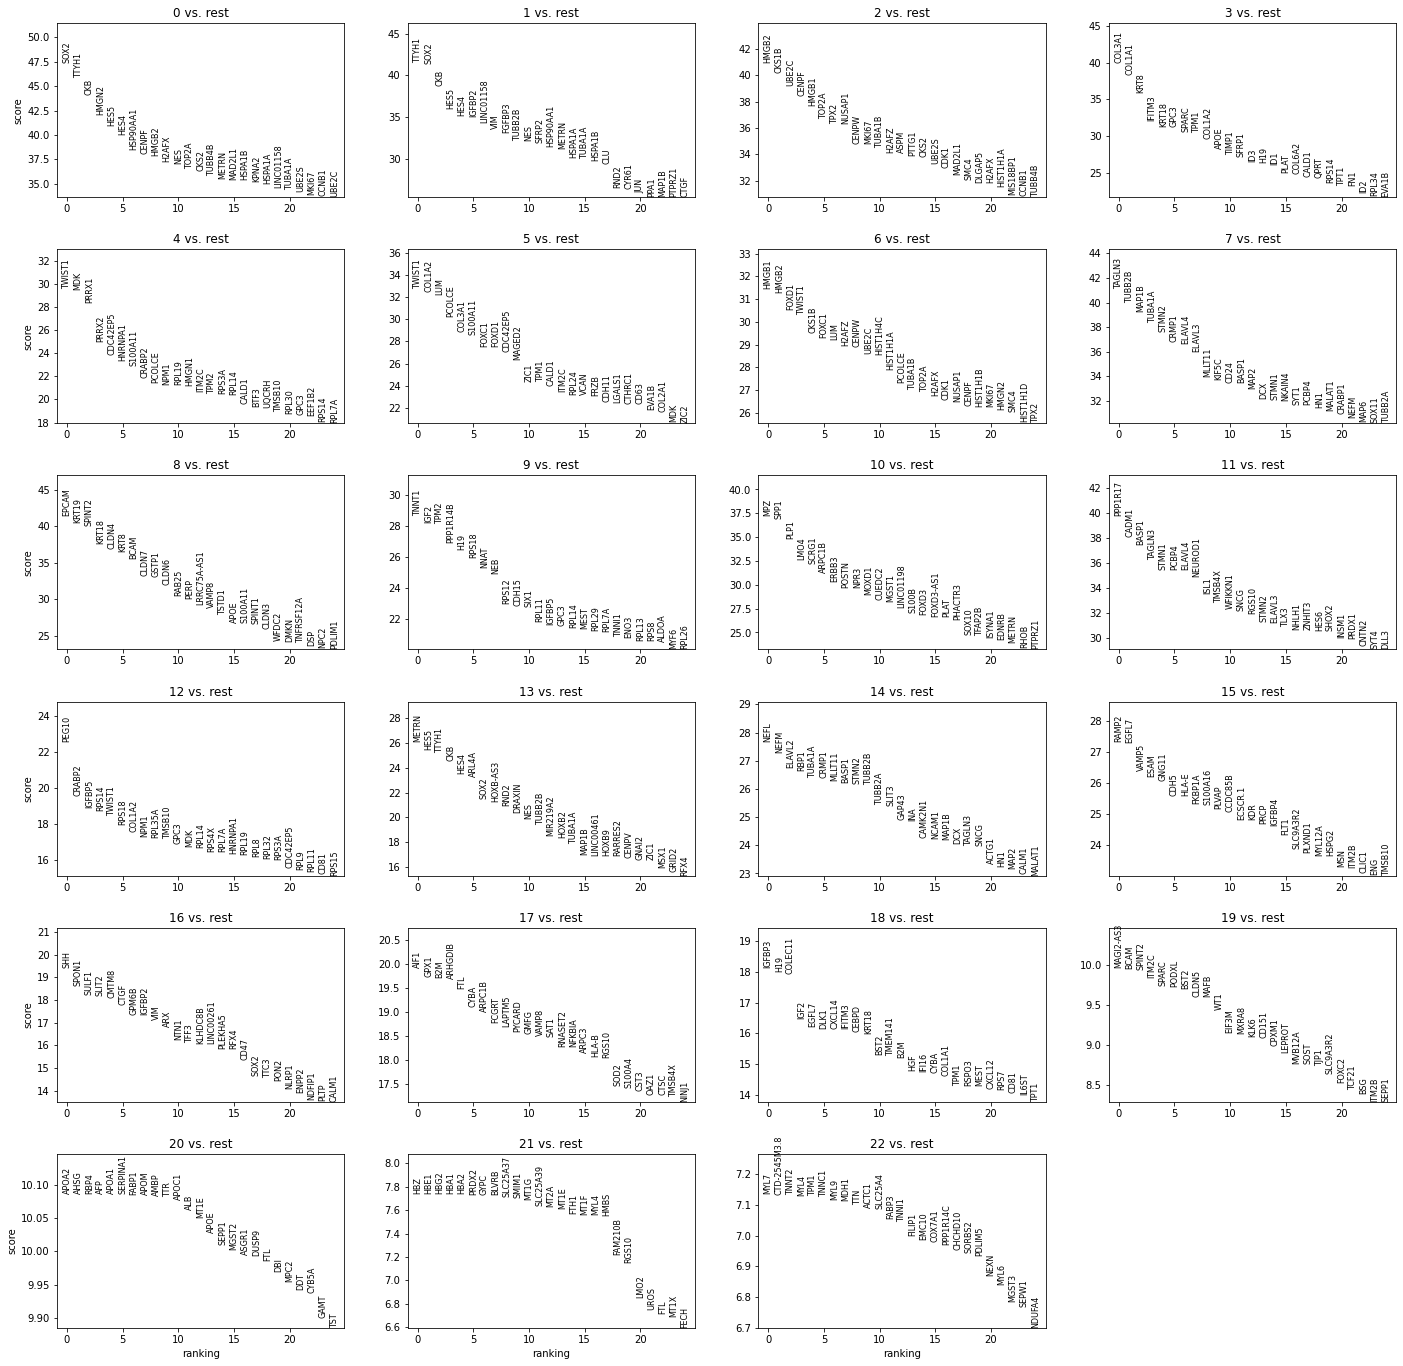

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:02:57)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


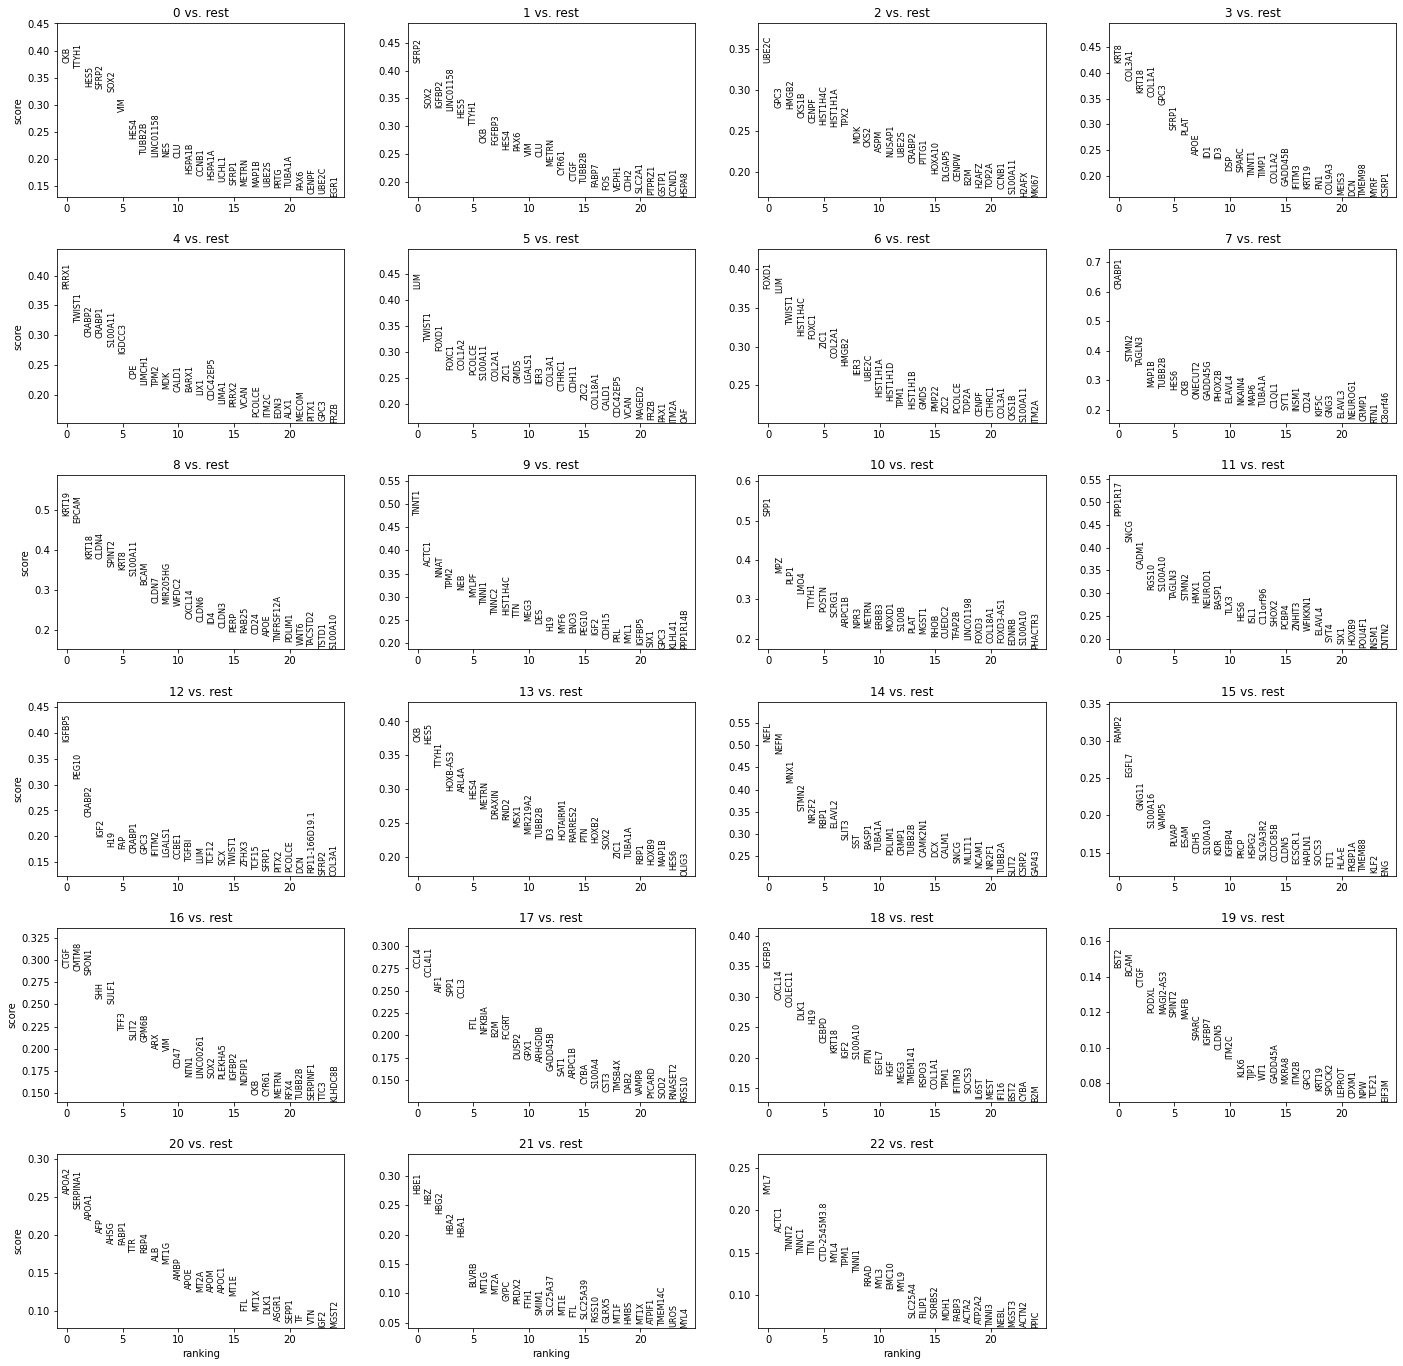

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
adata.write(results_file)

In [36]:
adata = sc.read(results_file)

In [37]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,SOX2,TTYH1,HMGB2,COL3A1,TWIST1,TWIST1,HMGB1,TAGLN3,EPCAM,TNNT1,...,METRN,NEFL,RAMP2,SHH,AIF1,IGFBP3,MAGI2-AS3,APOA2,HBZ,MYL7
1,TTYH1,SOX2,CKS1B,COL1A1,MDK,COL1A2,HMGB2,TUBB2B,KRT19,IGF2,...,HES5,NEFM,EGFL7,SPON1,GPX1,H19,BCAM,AHSG,HBE1,CTD-2545M3.8
2,CKB,CKB,UBE2C,KRT8,PRRX1,LUM,FOXD1,MAP1B,SPINT2,TPM2,...,TTYH1,ELAVL2,VAMP5,SULF1,B2M,COLEC11,SPINT2,RBP4,HBG2,TNNT2
3,HMGN2,HES5,CENPF,IFITM3,PRRX2,PCOLCE,TWIST1,TUBA1A,KRT18,PPP1R14B,...,CKB,RBP1,ESAM,SLIT2,ARHGDIB,IGF2,ITM2C,AFP,HBA1,MYL4
4,HES5,HES4,HMGB1,KRT18,CDC42EP5,COL3A1,CKS1B,STMN2,CLDN4,H19,...,HES4,TUBA1A,GNG11,CMTM8,FTL,EGFL7,SPARC,APOA1,HBA2,TPM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13131,RPS18,COL3A1,SOX2,HSPA1A,TUBA1A,HN1,FTL,MDK,NNAT,HES4,...,H3F3B,EEF1B2,TMSB15A,RPS23,NGFRAP1,CENPV,RPS12,TUBB,RPS4X,MARCKSL1
13132,RPL15,PCOLCE,MAP1B,TUBB,CKB,CD24,TUBA1A,NPM1,HSPA1A,COTL1,...,ITM2C,NPM1,CENPV,RPL37,CNN3,PRDX2,RPL10,STMN1,ACTG1,RPS19
13133,RPS14,COL1A2,TMSB4X,YBX1,CALM2,TUBA1A,CD24,ID3,MARCKS,HSP90AA1,...,COL1A2,RPLP1,PEBP1,EEF1B2,HNRNPA1,CD24,RPS3,H3F3A,RPL10,PTMA
13134,TPT1,S100A11,METRN,TUBA1B,HES4,CKB,CKB,RPL41.1,TUBA1A,PTN,...,S100A11,MDK,PRDX2,PTMA,MDK,HMGA1,RPL13,TUBA1A,RPL3,RPS3


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

ranking genes
    finished (0:00:04)


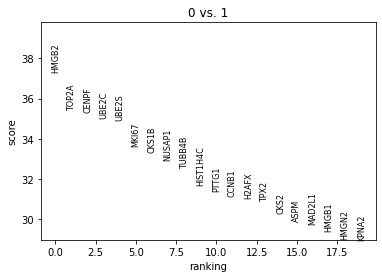

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

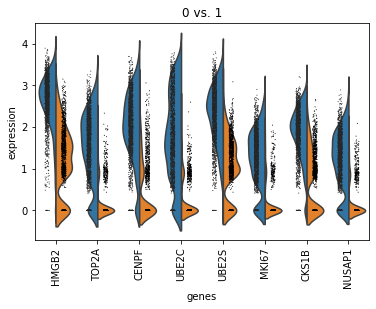

In [46]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [47]:
adata = sc.read(results_file)

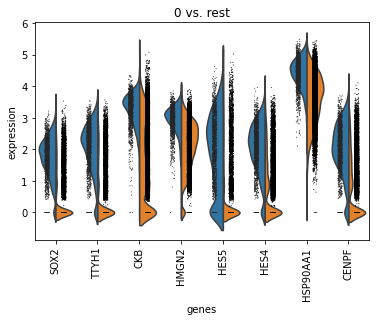

In [48]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

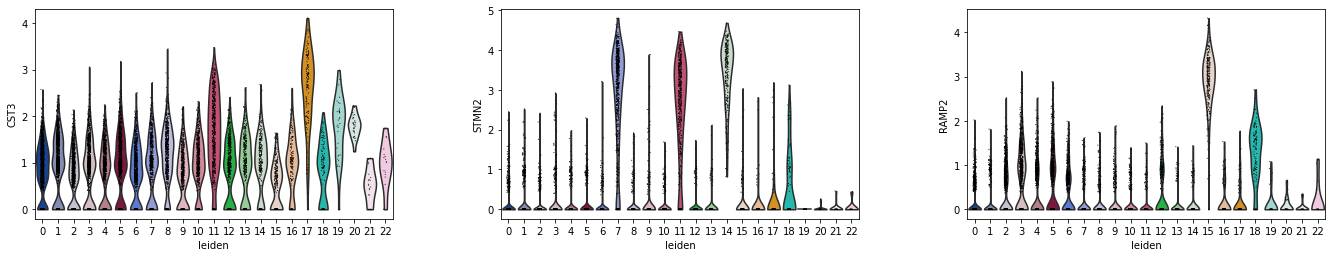

In [49]:
sc.pl.violin(adata, ['CST3', 'STMN2', 'RAMP2'], groupby='leiden', n_genes=8)

In [ ]:
# adata.obs['leiden'].cat.categories

In [ ]:
# new_cluster_names = [
#     'CD4 T', 'CD14 Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A Monocytes',
#     'Dendritic', 'Megakaryocytes']
# for i in range(23):
#     new_cluster_names.append(str(i))
# adata.rename_categories('leiden', new_cluster_names)
# # new_cluster_names

In [ ]:
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
# marker_genes = ['SAMD11', 'RP11-54O7.17', 'HES4', 'ISG15', 'ACAP3', 'TFF3', 'COL18A1',
#                 'COL6A2', 'S100B', 'DGCR6.1', 'STMN2', 'RAMP2', 'CST3']

In [ ]:
# sc.pl.dotplot(adata, marker_genes, groupby='leiden');

In [ ]:
# sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);